<h1>Audio Filtering - Digital Signal and Image Processing project</h1>
<h2>Federica Tamerisco S4942412</h2>

<h2>1. Theoretical background</h2>

To tackle the task of signal processing, we first have to introduce the concept of a <b>piece-wise continuous</b>: with this term we indicate a function $ f $ that is continuous in its period except for a finite number of jump discontinuities.<br>
Any piece-wise continuous can be expressed as a linear combination of properly normalized harmonic functions and it can be written as a <b>Fourier series expansion</b> of the function: $ f(t) = \sum_{n=0}^{\infty} f_n \, \phi_n(t) $.<br>
It represents a periodic signal as a sum of harmonics with discrete frequencies.<br>
We can generalize it to functions over the entire real line using the <b>Fourier Transform (FT)</b>: instead of decomposing a signal into discrete coefficients, it gives a continuous function of frequency $ \omega=2\pi v $.

We can consider also the <b>Fast Fourier Transform (FFT)</b> algorithm, that computes the <b>Discrete Fourier Transform (DFT)</b> and its inverse: the first is obtained by segmenting the sequence into pieces of different frequences, as depicted in the formula $ X_k = \sum_{m=0}^{n-1} x_m e^{-i2\pi km/n} \ $.

This theory can be applied in the context of audio filtering; however a simple Fourier Transform is not the best choice in the case of multiple frequencies inside the same plot, as it would result in a cluttered visualization.<br>
Therefore, we introduce the <b>Short-Time Fourier Transform (STFT)</b> [1] to produce a <b>spectogram</b>: a heatmap of time ($ x $ axis) and frequency ($ y $ axis), where each row is a frequency bin, while the colors depict different magnitude values (the "strength" of the components).<br>
In the code, the STFT is computed directly inside the <tt>plt.specgram()</tt> function [2].<br>
The signal $ x(t) $ is split into frames of equal length <tt>NFTT</tt>: in this case, it's set equal to the signal rate, so the length is 1 second.<br>
Then, each frame is multiplied by a <b>Hann window function</b> $ \omega(\tau) $, which is non-zero for only a short period of time.<br>
To compute the frequency spectrum, we apply a FFT to each frame to obtain the magnitude and to store it as a column on the spectogram.<br>
Since we have finite windows and fixed frequency bins, we are using a <b>Continous-Time STFT</b>: the corresponding equation is $ STFT\{x(t)\}(\tau,\omega)=X(\tau,\omega)= \int_{-\infty}^{+\infty} x(t)\omega(t-\tau)e^{-i\omega t} \, dt $.

In [104]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline

import IPython
import scipy.io.wavfile as wav

def stft(signal_rate, audio):
    plt.figure(figsize=(12, 5))
    spectrum, freqs, bins, img = plt.specgram(audio, NFFT = signal_rate, Fs = signal_rate, noverlap = int(signal_rate/2), cmap = plt.cm.Spectral, mode = 'magnitude', vmin=0, vmax=180)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.ylim(0, 2e3)
    plt.title("Spectrogram")
    plt.colorbar();

<h3>1.1 Linear Time-Invariant Systems</h3>

A physical system $ L $ is a transducer that takes the input signal $ f_i(t) $ and produces the output: $ L\{f_i(t)\}=f_o(t) $.<br>
As the name suggests, an LTI system is characterized by two main properties:

* <b>linearity</b><br>Considering two signals $ f_i(t) $ and $ g_i(t) $, if we perform an action on the input, it remains on the output: $ L\{af_i(t)+bg_i(t)\}=af_o(t)+bg_o(t) $
* <b>time-invariance</b><br>A time shift of the input produces the same time shift in the output: $ L\{f_i(t-s)\}=f_o(t-s) $

In the frequency domain, the quantitative measure of the magnitude and the phase of the output is the <b>frequency response</b> $ H(\omega) $ [5]: it relates the output to a sinusoidal input of frequency $ \omega $.<br>
It's also the FT of the <b>impulse response</b> $ h(t)=L\{\delta(t)\} $, that characterizes the system in the time domain.<br>
The output is given by the convolution of $ h(t) $ with the input: $ f_o(t)=(f_i*h)(t)=\int_{-\infty}^{+\infty} f_i(s)h(t-s) \, ds $.<br>
Considering the FT, in the frequency domain this becomes $ F_o(\omega)=F_i(\omega)H(\omega) $, where $ H(\omega) $ is the FT of the impulse response, called <b>system function</b>.<br>
If the impulse response is finite in duration, the system is called a <b>Finite Impulse Response (FIR)</b>: $ H(\omega) $ is a polynomial in $ e^{-i\omega} $.<br>
If instead it has an infinite duration, the system is an <b>Infinite Impulse Response (IIR)</b>: $ H(\omega) $ results in a rational function in $ e^{-i\omega} $, so we have $ H(\omega)=\frac{\sum_{n=0}^{N}b_ne^{-i\omega n} }{1+\sum_{n=1}^{M}a_ne^{-i\omega n} } $, where $ k $ is the discrete-time step of the impulse response.

If we take a continuous-time signal and we record it only at discrete time steps, we are sampling.<br>
We are essentially multiplying the signal by an infinite <b>impulse train</b> of period $ T_s $.<br>
In the time domain it corresponds to an infinite periodic repetition of the signal’s spectrum, centered around integer multiples of the sampling frequency $ \omega _s=\frac{2\pi}{T_s} $.<br>
The train can be described as

* $ i(t)=\sum_{n=-\infty}^{+\infty} \delta(t-nT_s) \ $
* $ i(t)=\frac{1}{T_s}\sum_{-\infty}^{+\infty} c_ke^{ikt\omega _s} $ (Fourier series form)

In this context, it's important to consider the <b>Nyquist frequency</b> $ \frac{\omega _s}{2} $ as the limit in sampling: as the <b>Shannon sampling theorem</b> states, if a signal contains no frequency components higher than the Nyquist frequency, you must sample at a rate $ \omega _s>2\omega _b $ to capture all its information without distortion.<br>
$ s_smp(\omega)=\frac{1}{T_s}\sum_{-\infty}^{+\infty} S(\omega -l\omega _s) $

<h3>1.2 Digital Filters</h3>

To observe how the spectrogram changes with different type of filtering, it's necessary to use a <b>Digital Filter</b> [3,4], that represents the signal like a sequence of numbers instead of using voltage or current.<br>
The raw signal is in the form of a voltage waveform described by the function $ V = x(t) $.<br>
An <b>Analog-to-Digital Converter</b> samples it at certain time intervals $ h $: the sampled value at time $ t=ih $ is $ x_i=x(ih) $.<br>
The resulting samples correspond to the values of the signal waveform at $ t=0,h,...,nh $ and they're described by representative binary numbers.<br>
Those are then passed through the processor (a PC or a Digital Signal Processor chip) that performs numerical calculations to produce a sequence of values $ y_0,...,y_n $.<br>
Lastly, this sequence is passed through a <b>Digital-to-Analog Converter</b>.

<img src="imgs/digital filter.png">

We can consider <b>linear filters</b>: they're LTI systems that can emphasize or suppress certain frequencies, depending on the case.<br>
The <b>gain</b> $ G(\omega) $ is how much the filter amplifies or attenuates the signal at a specific frequency, while the speed at which it changes is the <b>slope</b>, measured in decibels per octave.<br>
In this context we define
* <b>passband</b>: range of frequencies that pass through the filter
* <b>stopband</b>: range of frequencies that are rejected
* <b>transition band</b>: the in-between [14]

A so called <b>ideal filter</b> would have a flat passband, so all of the frequencies outside would be rejected completely.<br>
Its frequency response is a <b>rectangular function</b> $ p_T(t)= \begin{cases}
1 & -T<=t<=T \\
0 & otherwise
\end{cases} $.<br>
Unfortunately, applying an ideal filter is not possible without having signals of infinite extent time.<br>
Therefore, we generally approximate it by truncating and windowing into a FIR: this means that we are delaying the signal and seeing it manifesting into a phase shift.<br>
We have a region on the boundary of the passband where the frequencies that should be rejected are instead only attenuated.<br>
However, this can result in artifacts like the <b>Gibbs phenomenon</b>: we have some overshooting caused by high-frequency terms that can't be removed.

<img src="imgs/gibbs.png" style="width: 20rem">

The variety of windowing function can lead to a change in this effect.<br>
For example, when truncating the sinc function we create severe ringing artifacts, and those can be reduced using window functions that drop off more smoothly at the edges [5].

Given these terminologies, we define the different types of linear filters:

* <b>Low-Pass Filter (LPF)</b> and <b>High-Pass Filter (HPF)</b>
* <b>Band-Pass Filter (BPF)</b> and <b>Band-Stop Filter (BSF)</b>
* <b>Comb Filter</b>
* <b>All-Pass Filter (APF)</b>

To better understand the different effect of these filters on the same audio, I selected the first 2 macro-categories.<br>
We can design different families of filters depending on the desired frequency behavior:

* <b>Butterworth</b>
* <b>Chebyshev</b>
* <b>Bessel-Thomson</b>
* <b>Elliptic</b>

<h3>1.2.1 LPF</h3>

It attenuates the frequencies higher than a <b>cutoff frequency</b> [13]: the point where the transition band and passband meet, usually where the attenuation is 3 dB.

<img src="imgs/lpf.png">

It can be compared to a stiff physical barrier: when music is playing in another room, we hear the lower notes, while the higher ones are attenuated [7].<br>
Thus, it's used to

* remove hiss
* remove sibilance
* isolate bass tones

In this context, I chose to use the Butterworth filter: its main feature is that it has a <b>maximally flat frequence response</b> in the passband, rolling off towards zero in the stopband [9].<br>
This means that it doesn't have <b>ripples</b>: small oscillations in the gain.<br>
Its cutoff is not sharp, so it's used for general purposes but especially as a LP.

<img src="imgs/butterworth.png" style="width: 35rem">

The base formula of the analog magnitude is $ |H(\omega)|^2=\frac{G_0^2}{1+(\frac{\omega}{\omega _c})^{2n}} $, where

* $ G_0^2 $ is the passband gain
* $ n $ is the order of the filter

To use a Butterworth LPF we call the function <tt>signal.butter()</tt> [10], that takes as parameters:

* <tt>N</tt>: the order of the filter.
* <tt>Wn</tt>: the critical frequency.<br>For HP and LP it's scalar, while for BP and BS it's a sequence of length 2.
* <tt>btype</tt>: type of filtering to apply.
* <tt>analog</tt>: wheter or not to return an analog filter.

It returns numerator and denominator polynomials of the infinite impulse response filter.<br>
Inside the function we apply <tt>signal.lfilter()</tt> [11], that takes the results and uses them to filter the audio: the result is the output of the digital filter.<br>
At the end, we also apply <tt>np.fft.fft()</tt> to compute the FT by using the FFT and normalizing by the length of the audio.

In [ ]:
def butterworth(audio, order, Wn):
    numerator, denominator = signal.butter(N=order, Wn=Wn, btype="low", analog = False)

    output_df = signal.lfilter(numerator, denominator, audio)
    
    FT = np.fft.fft(output_df) / len(audio)

<h3>1.2.2 HPF</h3>

It attenuates the frequencies lower than the cutoff frequency.

<img src="imgs/hpf.png">

In the audio context, a specific type of HPF is the <b>rumble filter</b> [12], that removes the sounds closer to the lower end of the audible range (20-20.000 Hz).<br>
This is useful to

* isolate sources: e.g. since voice energy is above 80-100 Hz, we can isolate voice
* remove environmental noise
* remove plosives (vibrations due to the singer's breath into the microphone)
* remove handling noise

[15]

In this context, the most used is the Chebyshev filter: it has a steeper roll-off and it can minimize the error between the idealized filter and the normal one [17].<br>
We have an additional differentiation:

* Type I: most common, where the passband has a ripple 
* Type II: inverse filter, it doesn't roll off as fast and the ripple is in the stopband

<img src="imgs/chebyshevI.png">
<img src="imgs/chebyshevII.png">

Using the Type I as a HPF is optimal as it has a sharp cutoff, while maintaining a reasonable passband shape.<br>
The base analog magnitude is $ |H(\omega)|^2=\frac{G_0^2}{\sqrt{1+\epsilon^2T_n^2\frac{\omega}{\omega _c}}} $, where

* $ \epsilon $ is the ripple factor
* $ T_n(x) $ is the Chebyshev polynomial of degree $ n $

To implement it, we call the function <tt></tt>

<h3>1.2.3 BPF </h3>

It passes frequencies inside the passband and rejects the remainings [16].

<img src="imgs/bpf.png">

It can be constructed by joining in series a HPF, to allow components higher than a cutoff frequency, with a LPF to let through the frequencies lower than another cutoff frequency.<br>
The <b>bandwidth</b> of the filter is the difference between the two frequencies.<br
To choose the cutoff frequencies, we use the <b>shape factor</b>: the ratio of bandwidths using two different attenuations.<br>
The resulting shape of the bands is characterized by the <b>$Q$-factor</b>: the reciprical of the fractional bandwidth.<br>
Therefore, with a high-$Q$ filter we have a narrow passband, while with a low-$Q$ filter we have a wide passband.<br>
Since it can cut both the high and low frequencies, it's used to isolate certain elements of a track (voice, instrument etc.).

In this case, the family to use is Bessel-Thomson [19]: it has a flat phase delay, which preserves the wave shape of filtered signals in the passband.<br>
It's very similar to a Gaussian filter, but it has a small overshoot, which is still less than the one in e.g. Butterworth.

<img src="imgs/bessel.png">

It's excellent when time response is critical, however it has the slowest roll-off, so it’s not great if you need very sharp frequency separation.<br>
The analog magnitude is $ H(\omega)=G_0\frac{\theta _n(0)}{\theta _n(\frac{\omega}{\omega _c})} $, where $ \theta _n(0) $ is the Bessel polynomial of order $ n $.

To apply it, we use the function <tt></tt>

<h3>1.2.4 BSF</h3>

It's the inverse of the BPF [8].<br>

<img src="imgs/bsf.png">

When the stopband is particularly narrow with a high-$Q$ factor, we have a <b>notch filter</b>.<br>
They're used to reduce or prevent audio feedback: the high-pitched noise caused by the proximity between the microphone and the loudspeaker.<br>
Typically, the frequencies vary by semitones, so the width of the stopband is influenced by this.<br>
A common application of the BSF is the <b>anti-hum filter</b>, that suppresses the range 59-61 Hz characteristic of the alternating current sound.

In this case, we use the Elliptic/Cauer filter [20]: it has a ripple in both the passband and stopband.<br>

<img src="imgs/elliptic.PNG">

Feature: Steepest roll-off for a given filter order, but has ripple in both passband and stopband.

Use in audio: Very efficient when you need very tight filtering (e.g., in digital audio processing, anti-aliasing, or reconstruction filters).

Drawback: Phase distortion and ripple make it less “transparent” for high-fidelity audio.

The analog magnitude is $ |H(\omega)|^2=\frac{G_0^2}{\sqrt{1+\epsilon^2R_n^2(\frac{\omega}{\omega _c},k)}} $, where

* $ R_n(x,k) $ is the elliptic rational function
* $ k $ is the elliptic modulus

CONTROLLA

---

<h2>2. Experiments</h2>
I decided to approach the topic using different types of audios as starting points, to have a broader range of frequencies and elements:

1. clean audiobook extract
2. audio with background noise
3. instrumental music
3. rock song

<h3>2.1 Audiobook extract</h3>
For this first part of the project I decided to start from a "simple" audio, which is an extract from the <a href="youtube.com/watch?v=osyVY3VQDzY&t=14323s&pp=0gcJCa0JAYcqIYzv">audiobook of <i>Looking for Alaska</i></a> by <i>John Green</i>.

In [97]:
path = "audio/Looking_For_Alaska_extract.wav"

IPython.display.Audio(path, rate=44100)

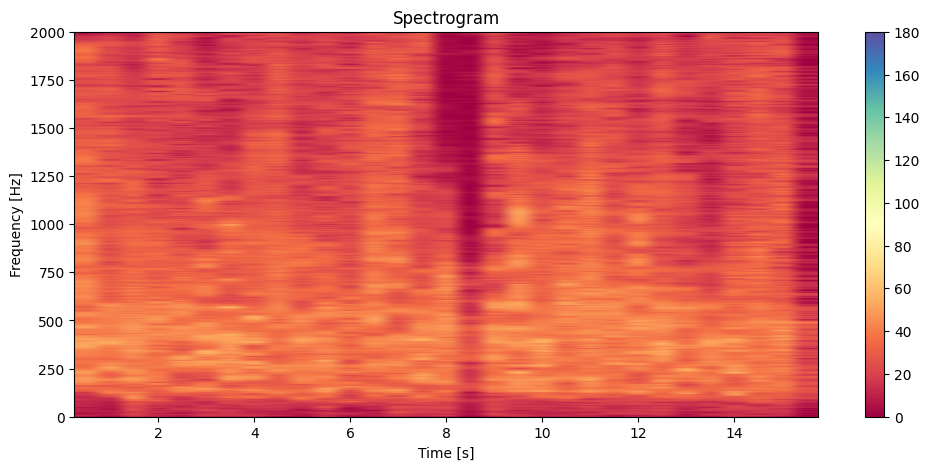

In [ ]:
signal_rate, audio = wav.read(path)
stft(signal_rate, audio)

As we can see by the spectrogram, the frequencies tend to stay in the interval of approximately 0-80 Hz.<br>
This is expected, as the only sound is a male voice, which ranges normally between those two values.<br>

I started by applying a Butterworth LPF.

In [ ]:
nyq_freq = signal_rate/2
critical_freq = 3000

butterworth(audio, 4, critical_freq/nyq_freq)

<h3>2.2 Audio with background noise</h3>

<h3>2.3 Instrumental music</h3>
I chose a snippet from the <a href="https://www.youtube.com/watch?v=KSKn8FKOPu4"><i>Memories of a Sound</i></a> by <i>Taisei Iwasaki</i>.

In [100]:
path = "audio/Memories_of_a_Sound_extract.wav"

IPython.display.Audio(path, rate=44100)

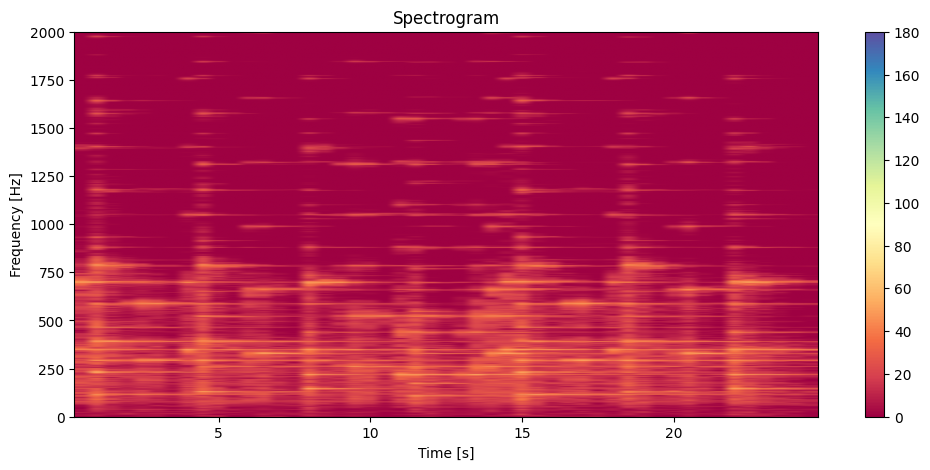

In [101]:
signal_rate, audio = wav.read(path)
stft(signal_rate, audio)

Also in this case the spectrogram shows a majority of red with frequencies approximately in the same range as before.<br>
The difference in this case is that the amount of lower frequencies is much higher: this is because, since it's a single instrument track, the pauses between the notes are only filled with an eco of the previous note.(?)

<h3>2.4 Rock song</h3>
I extracted a part of the song <a href="https://www.youtube.com/watch?v=NdYWuo9OFAw"><i>Iris</i></a> by <i>The Goo Goo Dolls</i>.

In [102]:
path = "audio/Iris_extract.wav"

IPython.display.Audio(path, rate=44100)

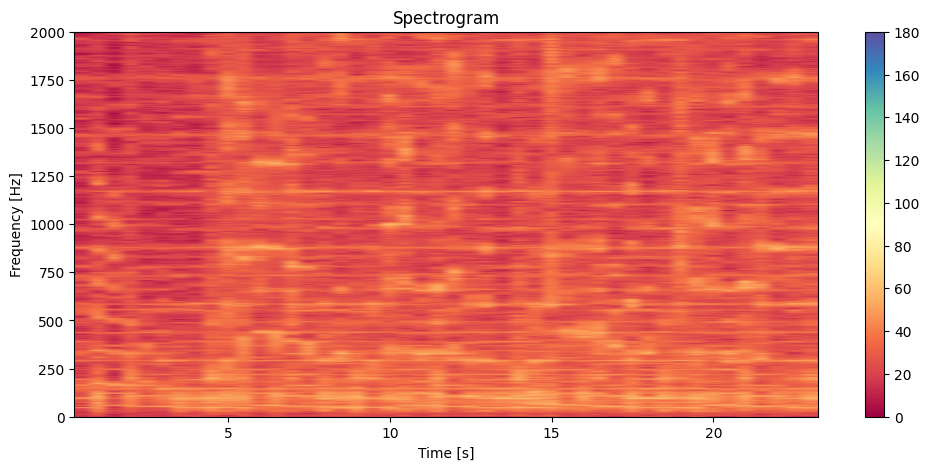

In [103]:
signal_rate, audio = wav.read(path)
stft(signal_rate, audio)

In this case, the spectrogram shows a larger amount of higher frequencies, even if they stay always in the same range of the previous steps.<br>
The singer tone ranges from lower to higher octaves but it doesn't spatiate to much.<br>
The instruments ...

---

<h2>Bibliography</h2>

[1] <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform">Short-time Fourier transform</a>, <i>Wikipedia</i> 

[2] <a href="https://matplotlib.org/stable/api/%5C_as%5C_gen/matplotlib.pyplot.specgram.html">matplotlib.pyplot.specgram</a>, <i>matplotlib</i>

[3] <a href="https://123.physics.ucdavis.edu/week_5_files/filters/digital_filter.pdf?">INTRODUCTION TO DIGITAL FILTERS</a>, <i>UCDavis</i>

[4] <a href="https://en.wikipedia.org/wiki/Digital_filter">Digital Filter</a>, <i>Wikipedia</i>

[5] <a href="https://en.wikipedia.org/wiki/Frequency_response">Frequency Response</a>, <i>Wikipedia</i>

[6] <a href="https://www.allaboutcircuits.com/technical-articles/low-pass-filter-tutorial-basics-passive-RC-filter/">What Is a Low Pass Filter? A Tutorial on the Basics of Passive RC Filters</a>, <i>All About Circuits</i>

[7] <a href="https://en.wikipedia.org/wiki/Low-pass_filter">Low-pass filter</a>, <i>Wikipedia</i>

[8] <a href="https://en.wikipedia.org/wiki/Band-stop_filter">Band-stop filter</a>, <i>Wikipedia</i>

[9] <a href="https://en.wikipedia.org/wiki/Butterworth_filter">Butterworth filter</a>, <i>Wikipedia</i>

[10] <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html">scipy.signal.butter</a>, <i>SciPy</i>

[11] <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html">scipy.signal.lfilter</a>, <i>SciPy</i>

[12] <a href="https://en.wikipedia.org/wiki/High-pass_filter">High-pass filter</a>, <i>Wikipedia</i>

[13] <a href="https://en.wikipedia.org/wiki/Cutoff_frequency">Cutoff frequency</a>, <i>Wikipedia</i>

[14] <a href="https://en.wikipedia.org/wiki/Filter_(signal_processing)">Filter (signal processing)</a>, <i>Wikipedia</i>

[15] <a href="https://audiouniversityonline.com/audio-high-pass-filters/">What Are Audio HIGH PASS FILTERS & How to Use Them</a>, <i>Audio University</i>

[16] <a href="https://en.wikipedia.org/wiki/Band-pass_filter">Band-pass filter</a>, <i>Wikipedia</i>

[17] <a href="https://en.wikipedia.org/wiki/Chebyshev_filter">Chebyshev filter</a>, <i>Wikipedia</i>

[18] <a href="https://en.wikipedia.org/wiki/Bilinear_transform">Bilinear transform</a>, <i>Wikipedia</i>

[19] <a href="https://en.wikipedia.org/wiki/Bessel_filter">Bessel filter</a>, <i>Wikipedia</i>

[20] <a href="https://en.wikipedia.org/wiki/Elliptic_filter">Elliptic filter</a>, <i>Wikipedia</i>